In [41]:
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import rcParams
from termcolor import colored
import scipy.stats as stats
import seaborn as sns
import numpy as np  
from prettytable import PrettyTable
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
from datetime import date, timedelta

In [129]:
class ForecastPetroleo():
    def __init__(self, ticker="BZ=F"):
        self.ticker = ticker
        self.data = yf.download(ticker)
        self.df = self.create_features(self.data)
        
    def fit(self):
        return self
    
    def create_features(self, df):
        data_frame = df.copy()
        data_frame["data"] = pd.to_datetime(df.index)
        data_frame['ano'] = data_frame['data'].dt.year
        data_frame['mes'] = data_frame['data'].dt.month
        data_frame['dia'] = data_frame['data'].dt.day
        data_frame.rename(columns={'Close': 'valor_fechamento'}, inplace=True)
        data_frame.rename(columns={'Open': 'valor_abertura'}, inplace=True)        
        data_frame['dia_da_semana'] = data_frame['data'].dt.dayofweek
        
        return data_frame

    
    def calculate_metrics(self, y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = root_mean_squared_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        return mae, mse, mape


    def print_metrics(self, metrics):
        mae, mse, mape = metrics
        print(colored(f"MAE: {mae}", 'light_blue'))
        print(colored(f"MSE: {mse}", 'light_cyan'))
        print(colored(f"MAPE: {mape:.2f} %", 'light_green'))

    def prepare_data(self):
        df_feature = self.df.copy()
        df_feature.sort_values(by = 'data', inplace=True)
        feature_names = ["ano", "mes", "dia", "dia_da_semana"]
        target = "valor_fechamento"

        X = df_feature[feature_names]
        y = df_feature[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

        print(f"X_train: {X_train.shape}")
        print(f"X_test: {X_test.shape}")        

        return X_train, X_test, y_train, y_test
    
    def train_model(self, X_train, y_train):
        model = xgb.XGBRegressor(objective="reg:squarederror")
        model.fit(X_train, y_train)
        return model
    
    def evaluate_model(self, model, X_test, y_test):
        y_pred = model.predict(X_test)
        mae, mse, mape = self.calculate_metrics(y_test, y_pred)
        self.print_metrics((mae, mse, mape))
        return y_pred    
    
    def plot_predictions_with_test(self, y_test, y_pred):
        plt.plot(y_test.index, y_test, label="Valor Real")
        plt.plot(y_test.index, y_pred, label="Valor Previsto_teste")        
        plt.legend()
        plt.xticks(rotation=45, ha='right') 
        plt.show()
    
    def plot_predictions(self, y_pred):
        plt.plot(y_pred.index, y_pred['valor_fechamento'], label="Valor Previsto")
        plt.legend()
        plt.xticks(rotation=45, ha='right') 
        plt.show()
        

    def configure_days(self, first_date, num_days=1):        

          # Converte a data inicial para o tipo datetime, se necessário
        if isinstance(first_date, str):
            first_date = pd.to_datetime(first_date)

        # Cria um range de datas futuras
        future_dates = pd.date_range(start=first_date, periods=num_days + 1)

        # Remove a data inicial, deixando apenas as datas futuras
        future_dates = future_dates[1:]

        return future_dates
    def prepare_dates(self, dates):
        df_feature = pd.to_datetime(dates)
        df_feature = df_feature.to_frame()
        df_feature['ano'] = df_feature.index.year
        df_feature['mes'] = df_feature.index.month
        df_feature['dia'] = df_feature.index.day
        df_feature['dia_da_semana'] = df_feature.index.dayofweek
        df_feature.reset_index(drop=True, inplace=True)
        df_feature.drop(columns=[0], inplace=True)
        
        return df_feature

    def final_predictions(self, dates_for_predict,y_pred_final):
        df_final = pd.merge(dates_for_predict, pd.DataFrame(y_pred_final), left_index=True, right_index=True)
        df_final['data'] = df_final['ano'].astype(str) + '-' + df_final['mes'].astype(str).str.zfill(2) + '-' + df_final['dia'].astype(str).str.zfill(2)
        df_final['data'] = pd.to_datetime(df_final['data'], format='%Y-%m-%d')

        print(df_final)
        df_final = df_final.set_index('data')
        df_final.rename(columns = {0: 'valor_fechamento'}, inplace=True)

        return df_final

    def predict_days(self, days=10):
        X_train, X_test, y_train, y_test = self.prepare_data()
        model = self.train_model(X_train, y_train)
        y_pred = self.evaluate_model(model, X_test, y_test)
        
        dates_for_predict = self.configure_days(self.df.index[-1], days)        
        dates_for_predict = self.prepare_dates(dates_for_predict)
        y_pred_final = model.predict(dates_for_predict)
        self.plot_predictions_with_test(y_test, y_pred)        
        df_final_predict  = self.final_predictions(dates_for_predict, y_pred_final)
        
        self.plot_predictions(df_final_predict)
        
        
        return df_final_predict


[*********************100%***********************]  1 of 1 completed


X_train: (3924, 4)
X_test: (436, 4)
MAE: 5.581350484025588
MSE: 7.0354392744143395
MAPE: 6.72 %


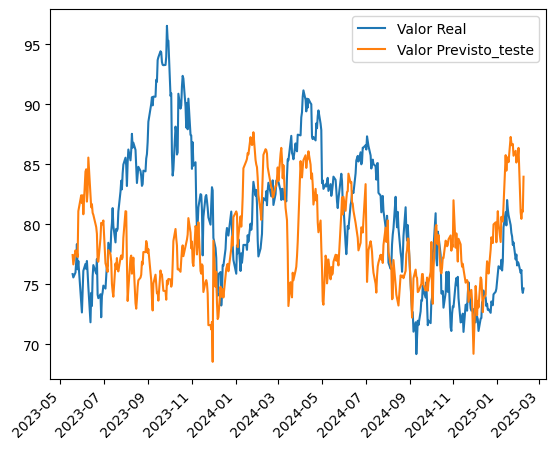

     ano  mes  dia  dia_da_semana          0       data
0   2025    2    8              5  85.287315 2025-02-08
1   2025    2    9              6  85.796402 2025-02-09
2   2025    2   10              0  84.525642 2025-02-10
3   2025    2   11              1  84.584656 2025-02-11
4   2025    2   12              2  86.174294 2025-02-12
5   2025    2   13              3  86.665405 2025-02-13
6   2025    2   14              4  85.444115 2025-02-14
7   2025    2   15              5  84.416618 2025-02-15
8   2025    2   16              6  84.422325 2025-02-16
9   2025    2   17              0  84.451790 2025-02-17
10  2025    2   18              1  83.834999 2025-02-18
11  2025    2   19              2  83.812904 2025-02-19
12  2025    2   20              3  82.946167 2025-02-20
13  2025    2   21              4  82.858131 2025-02-21
14  2025    2   22              5  81.853722 2025-02-22
15  2025    2   23              6  82.309502 2025-02-23
16  2025    2   24              0  83.541458 202

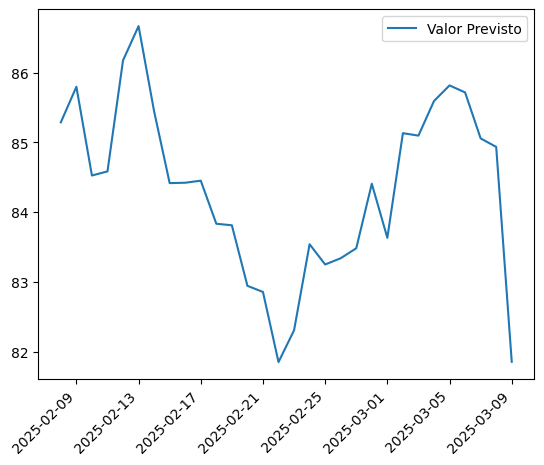

,ano,mes,dia,dia_da_semana,valor_fechamento
data,,,,,
2025-02-08,2025,2,8,5,85.287315
2025-02-09,2025,2,9,6,85.796402
2025-02-10,2025,2,10,0,84.525642
2025-02-11,2025,2,11,1,84.584656
2025-02-12,2025,2,12,2,86.174294
2025-02-13,2025,2,13,3,86.665405
2025-02-14,2025,2,14,4,85.444115
2025-02-15,2025,2,15,5,84.416618
2025-02-16,2025,2,16,6,84.422325


In [131]:
forecast = ForecastPetroleo()
forecast.predict_days(30)